# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Riemannian metrics

In this notebook, we solve Riemannian eikonal equations on the CPU and the GPU, and check that they produce consistent results.

**GPU performance** GPUs are massively parallel machines, which efficiently exploit cache locality. Hence they are at their advantage with :
* Large problem instances, which are embarassingly parallel
* Moderate anisotropy, so that the numerical scheme stncils are not too wide

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Isotropic metric](#1.1-Isotropic-metric)
    * [1.2 Smooth anisotropic metric](#1.2-Smooth-anisotropic-metric)
  * [2. Three dimensions](#2.-Three-dimensions)
    * [2.1 Smooth anisotropic metric](#2.1-Smooth-anisotropic-metric)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Riemann_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare
Eikonal.dictIn.default_mode = 'gpu'

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,RunGPU,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)

### 0.1 Additional configuration

In [6]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 
anisotropy_bound = 10. if strong_anisotropy else 4. # Ratio between the fastest and the smallest velocity at any given point

In [7]:
def surface_metric(x,z,mu):
    ndim,shape = x.ndim-1,x.shape[1:]
    x_ad = ad.Dense.identity(constant=x,shape_free=(ndim,))
    tensors = lp.outer_self( z(x_ad).gradient() ) + mu**-2 * fd.as_field(cp.eye(ndim),shape)
    return Metrics.Riemann(tensors)

## 1. Two dimensions

### 1.1 Isotropic metric

In [8]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'metric':Metrics.Riemann.from_cast(Metrics.Isotropic(cp.array(1.),vdim=2)),
    'seed':[0.5,0.5],
    'exportValues':1,
#    'bound_active_blocks':True,
    'traits':{
        'niter_i':24,'shape_i':(12,12), # Best
    }
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [9]:
_,cpuOut = RunCompare(hfmIn,check=1e-5)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.15498590469360352 seconds, and 115 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.834 s.
Solver time (s). GPU : 0.15498590469360352, CPU : 1.505. Device acceleration : 9.71056047306548
Max |gpuValues-cpuValues| :  2.91457399725914e-06


In [10]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
cost = np.prod(np.sin(2*np.pi*X),axis=0)+1.1
hfmInS.update({
    'metric': Metrics.Riemann.from_cast(Metrics.Isotropic(cost,vdim=2)), # Isotropic but non-constant metric
    'verbosity':0,
})

In [11]:
RunCompare(hfmInS,variants='basic')

Solver time (s). GPU : 0.02801513671875, CPU : 0.051000000000000004. Device acceleration : 1.8204444444444445
Max |gpuValues-cpuValues| :  1.2986592052843804e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.023499488830566406, CPU : 0.052. Device acceleration : 2.212814090337243
Max |gpuValues-cpuValues| :  4.2754584872461976e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.021994590759277344, CPU : 0.051000000000000004. Device acceleration : 2.318751940337337
Max |gpuValues-cpuValues| :  1.2510731657311425e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.025506019592285156, CPU : 0.051000000000000004. Device acceleration : 1.9995279865395403
Max |gpuValues-cpuValues| :  5.180311657415615e-08


In [12]:
RunCompare(hfmInS,variants='ext',check=0.004)

Solver time (s). GPU : 0.02651524543762207, CPU : 0.051000000000000004. Device acceleration : 1.923421758247687
Max |gpuValues-cpuValues| :  1.2986592052843804e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.0254974365234375, CPU : 0.051000000000000004. Device acceleration : 2.000201077199282
Max |gpuValues-cpuValues| :  4.2754584872461976e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.02199411392211914, CPU : 0.052. Device acceleration : 2.364268921409214
Max |gpuValues-cpuValues| :  1.2510731657311425e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.022500991821289062, CPU : 0.05. Device acceleration : 2.2221242688819194
Max |gpuValues-cpuValues| :  5.180311657415615e-08

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.027513980865478516, CPU : 0.054. Device acceleration : 1.9626385677891198
Max |gpuValues-cpuValues| :  0.0009697289038162471

 --- V

### 1.2 Smooth anisotropic metric

In [13]:
n=3000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'seed':[0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':8,'shape_i':(8,8),},'fim_front_width':4, 
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)

In [14]:
def height(x): 
    r = fd.as_field(lp.rotation(cp.asarray(np.pi)/3),x.shape[1:])
    y = 2*lp.dot_AV(r,x)
    return np.sin(y[0])*np.sin(y[1]) 

In [15]:
hfmIn['metric'] = surface_metric(hfmIn.Grid(),height,mu=anisotropy_bound)

In [16]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.3034980297088623 seconds, and 374 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.8 s.
Solver time (s). GPU : 0.3034980297088623, CPU : 2.9859999999999998. Device acceleration : 9.838614118399356
Max |gpuValues-cpuValues| :  2.410463604829438e-05


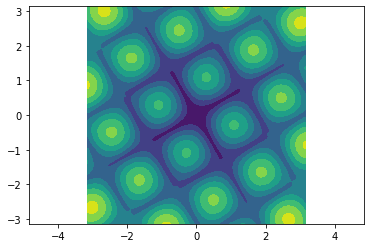

In [18]:
plt.contourf(*hfmIn.Grid(),gpuOut['values']) 
plt.axis('equal');

In [19]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
hfmInS.update({
    'metric' : surface_metric(hfmInS.Grid(),height,mu=anisotropy_bound), 
    'verbosity':0,
})

In [20]:
RunCompare(hfmInS,variants='basic',check=0.0008)

Solver time (s). GPU : 0.049498558044433594, CPU : 0.10400000000000001. Device acceleration : 2.101071306090207
Max |gpuValues-cpuValues| :  1.2892357243998731e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.04999995231628418, CPU : 0.10400000000000001. Device acceleration : 2.08000198364447
Max |gpuValues-cpuValues| :  3.1663243316160106e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.04552483558654785, CPU : 0.10400000000000001. Device acceleration : 2.284467338762471
Max |gpuValues-cpuValues| :  0.0005127490260626571

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.04750227928161621, CPU : 0.10400000000000001. Device acceleration : 2.189368627628125
Max |gpuValues-cpuValues| :  0.0005127490260626571


Source factorization is implemented differently, and not applied on the same domain (square vs disk), between the CPU and GPU implementations. Hence the results differ somewhat more : there is no bit-consistency.

<!---
Due to the different switching criteria of the second order scheme, we do not have bit consistency in that case. The results are nevertheless quite close. Note also that we do not deactivate the `decreasing` trait here, contrary to the isotropic case, because the scheme often does not converge without it.

**Bottom line.** Second order accuracy for anisotropic metrics on the GPU is very experimental, and not much reliable, at this stage. Further investigation is needed on the matter.
--->

In [23]:
RunCompare(hfmInS,variants='ext',check=0.008)

Solver time (s). GPU : 0.051514625549316406, CPU : 0.10400000000000001. Device acceleration : 2.0188441416591076
Max |gpuValues-cpuValues| :  1.2892357243998731e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.05049276351928711, CPU : 0.10200000000000001. Device acceleration : 2.0200914525313767
Max |gpuValues-cpuValues| :  3.1663243316160106e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.04647946357727051, CPU : 0.10300000000000001. Device acceleration : 2.21603245977153
Max |gpuValues-cpuValues| :  0.0005127490260626571

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.055989742279052734, CPU : 0.11. Device acceleration : 1.9646455854674285
Max |gpuValues-cpuValues| :  0.0005127490260626571

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.04634428024291992, CPU : 0.106. Device acceleration : 2.287229393668138
Max |gpuValues-cpuValues| :  0.005569868667836

Second order accuracy for anisotropic metrics on the GPU is only experimental, and not reliable, at this stage. Further investigation is needed on the matter.
Even obtaining the scheme convergence is hard, and requires setting some other parameters carefully and conservatively.

<!---
hfmInS.update({
    'order2_threshold':0.03,
    'verbosity':1,
    'traits':{'decreasing_macro':0,'order2_threshold_weighted_macro':1},
    'metric' : surface_metric(hfmInS.Grid(),height),
    'multiprecision':False,
    'tol':1e-6
})
--->

In [26]:
hfmInS.update({
    'tol':1e-6, # Tolerance for the convergence of the fixed point solver
    'order2_threshold':0.03, # Use first order scheme if second order difference is too large
    'traits':{'decreasing_macro':0}, # Do not enforce monotonicity
})

In [27]:
RunCompare(hfmInS,variants='ext2',check=0.3)

Solver time (s). GPU : 0.04399824142456055, CPU : 0.10200000000000001. Device acceleration : 2.318274474103456
Max |gpuValues-cpuValues| :  1.1700264348490919e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.04400992393493652, CPU : 0.10200000000000001. Device acceleration : 2.317659084137363
Max |gpuValues-cpuValues| :  1.1130146319038303e-06

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.04700446128845215, CPU : 0.10500000000000001. Device acceleration : 2.233830515696091
Max |gpuValues-cpuValues| :  0.0005127490260626571

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.05251669883728027, CPU : 0.10400000000000001. Device acceleration : 1.9803224936555426
Max |gpuValues-cpuValues| :  0.0005127490260626571

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.056015968322753906, CPU : 0.109. Device acceleration : 1.9458737082247988
Max |gpuValues-cpuValues| :  0.0

In [28]:
# TODO : discontinuous metric

## 2. Three dimensions

### 2.1 Smooth anisotropic metric

We generalize the two dimensional test case, although it does not much make geometrical sense anymore: we are computing geodesics in a three dimensional volume viewed as an hypersurface embedded in four dimensional Euclidean space.

In [29]:
n=200 if large_instances else 100
hfmIn = Eikonal.dictIn({
    'model':'Riemann3',
    'seed':[0.,0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':4},'fim_front_width':6,
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)

In [42]:
def height3(x): 
    r = fd.as_field(lp.rotation(cp.asarray(np.pi)/3,cp.asarray((1.,2,3))),x.shape[1:])
    y = 2*lp.dot_AV(r,x)
#    y=x
    return np.sin(y[0])*np.sin(y[1])*np.sin(y[2])

In [31]:
hfmIn['metric'] = surface_metric(hfmIn.Grid(),height3,mu=anisotropy_bound)

In [32]:
gpuOut,cpuOut = RunCompare(hfmIn,check=1e-4)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.1405198574066162 seconds, and 92 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 6.513 s.
Solver time (s). GPU : 0.1405198574066162, CPU : 10.201. Device acceleration : 72.59472211448244
Max |gpuValues-cpuValues| :  1.8024920708792358e-06


In [43]:
n=50; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
hfmInS.update({
    'metric' : surface_metric(hfmInS.Grid(),height3,mu=anisotropy_bound), 
    'verbosity':0,
})

In [46]:
RunCompare(hfmInS,variants='ext',check=0.02)

Solver time (s). GPU : 0.0440218448638916, CPU : 1.11. Device acceleration : 25.21475425284742
Max |gpuValues-cpuValues| :  4.720023937143658e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.05402207374572754, CPU : 1.094. Device acceleration : 20.25098120352186
Max |gpuValues-cpuValues| :  4.6604192923682675e-06

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.05250191688537598, CPU : 1.106. Device acceleration : 21.065897506459773
Max |gpuValues-cpuValues| :  0.004857792650190311

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.04799365997314453, CPU : 1.097. Device acceleration : 22.857185732737207
Max |gpuValues-cpuValues| :  0.0048577889249000125

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.05249333381652832, CPU : 1.131. Device acceleration : 21.545592892861524
Max |gpuValues-cpuValues| :  0.01243768179866405

 --- Variant {'factoringRadius': 10.0, 'fa

Again, the GPU implementation of the second order scheme is purely experimental at this stage, and should not be relied upon.

<!---
Due to the different switching criteria of the second order scheme, we do not have bit consistency in that case. The results are nevertheless quite close.
--->

In [47]:
RunCompare(hfmInS,variants='ext2',check=0.1)

Solver time (s). GPU : 0.04551982879638672, CPU : 1.105. Device acceleration : 24.275135237057675
Max |gpuValues-cpuValues| :  4.720023937143658e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.05752134323120117, CPU : 1.087. Device acceleration : 18.897333388598287
Max |gpuValues-cpuValues| :  4.6604192923682675e-06

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.04700517654418945, CPU : 1.105. Device acceleration : 23.50804913925155
Max |gpuValues-cpuValues| :  0.004857792650190311

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.057999372482299805, CPU : 1.113. Device acceleration : 19.18986279273391
Max |gpuValues-cpuValues| :  0.0048577889249000125

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.052519798278808594, CPU : 1.133. Device acceleration : 21.572817054348025
Max |gpuValues-cpuValues| :  0.01243768179866405

 --- Variant {'factoringRadius': 10.0,